<a href="https://colab.research.google.com/github/Shree-Divya-Ganesh/Shree-Divya-Ganesh/blob/master/Comments_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FB Prophet Algorithm 

## Forecasting Daily minimum Temperature of Melbourne


### Importing Necessary Libraries

In [0]:
# IMPORTING LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet   
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import plotly.express as px


### Importing Daily Temperature dataset 

In [6]:
from google.colab import files
uploaded = files.upload()

Saving temperature_dataset.xlsx to temperature_dataset (1).xlsx


Daily Minimum Temperature in Melbourne consists of temperatures measured in Celsius for a period of 10 years ( 1981 - 1990 )

In [0]:
temperature_data = pd.read_excel('temperature_dataset.xlsx')

### Data Handling

dataframe.shape : returns m rows and n columns available in the dataset


In [8]:
temperature_data.shape

(3650, 2)

describe( ) : provides a statistical summary with Inter Quartile Range and Descriptive Statistics ( Mean, Minimum, Maximum, Standard Deviation )


In [9]:
temperature_data.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,3650.0,11.177753,4.071837,0.0,8.3,11.0,14.0,26.3


head( ) : returns first five rows from the dataframe

In [0]:
temperature_data.head()

,date,temp,month
0,1981-01-01,20.7,1
1,1981-01-02,17.9,1
2,1981-01-03,18.8,1
3,1981-01-04,14.6,1
4,1981-01-05,15.8,1


### Renaming Column names into 'ds' and 'y'

Prophet model takes only two columns as input. The column name should be '**ds**' for datestamp and '**y**' representing numeric values

In [10]:
temperature_data.columns=['ds','y']

temperature_data.head()

,ds,y
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


### Exploratory Data Analysis


#### Using Plotly Library for Visualization of Temperature

Interactive Time Series Line Plot using Plotly. 

The data ranges from 1981 to 1990 with daily period. 

X-axis represents datestamp 'ds' column and Y-axis represents temeprature 'y' column.

In [0]:
fig = px.line(temperature_data, x='ds', y='y')
fig.show()

### Train Test Split

It is very important to have more number of data points in training set which makes the model learn from different scenarios.  

Here, 

*   Train set ranges from January 1981 to December 1989 ( Nine years ). 

*   Test set covers one year of data points ( January 1990 - December 1990 )




In [0]:
train_set = temperature_data[(temperature_data['ds'] >= '1981-01-01') & (temperature_data['ds'] <= '1989-12-31')]
test_set = temperature_data[(temperature_data.ds >= '1990-01-01')]

The number of observations present in training set is 3285 days and that of test set is 365 days

In [0]:
print(train_set.shape , test_set.shape)

(3285, 3) (365, 3)


### Training Prophet model with customized parameters to capture the trends/seasonality

#### Understanding of Parameters

There are few parameter components which are to be known and understood to make maximum out of the model for high-quality forecasts.

Listed below are the parameters which will be covered.

*   Growth
*   Seasoanlity
*   Saturating Growth
*   Changepoints
*   Regressors
*   Holidays / Events

We can also adjust the parameter values for the listed components which reflects in our model results.  









In [0]:
m = Prophet(growth='logistic',seasonality_mode='multiplicative',changepoint_prior_scale=0.1,daily_seasonality=True).add_seasonality(name='yearly',period=365,fourier_order=48).add_seasonality(name='quarterly',period=91.25,fourier_order=48)
temperature_data['cap'] = 30
temperature_data['floor'] = 0
m.fit(temperature_data)

INFO:fbprophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.


### Defining the number of periods ( days ) for which model will forecast 

In [0]:
future_set = m.make_future_dataframe(periods=7) # periods = 365 ( number of days in a year in 365 / Number of records in test set  )
future_set['cap'] = 30 
future_set['floor'] = 0

### Forecasting the temperature for the defined period and visualizing the forecast components

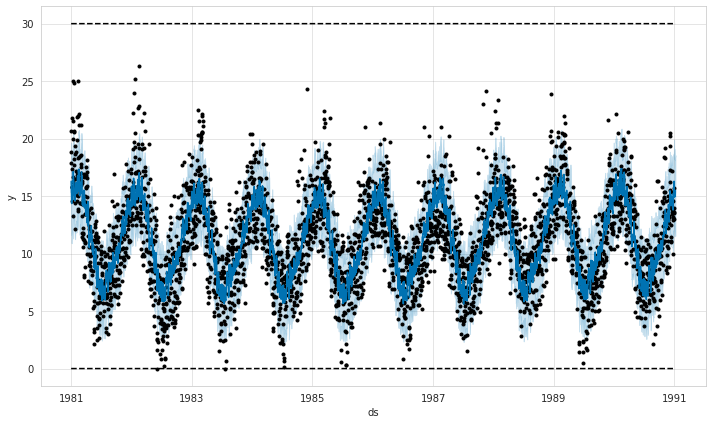

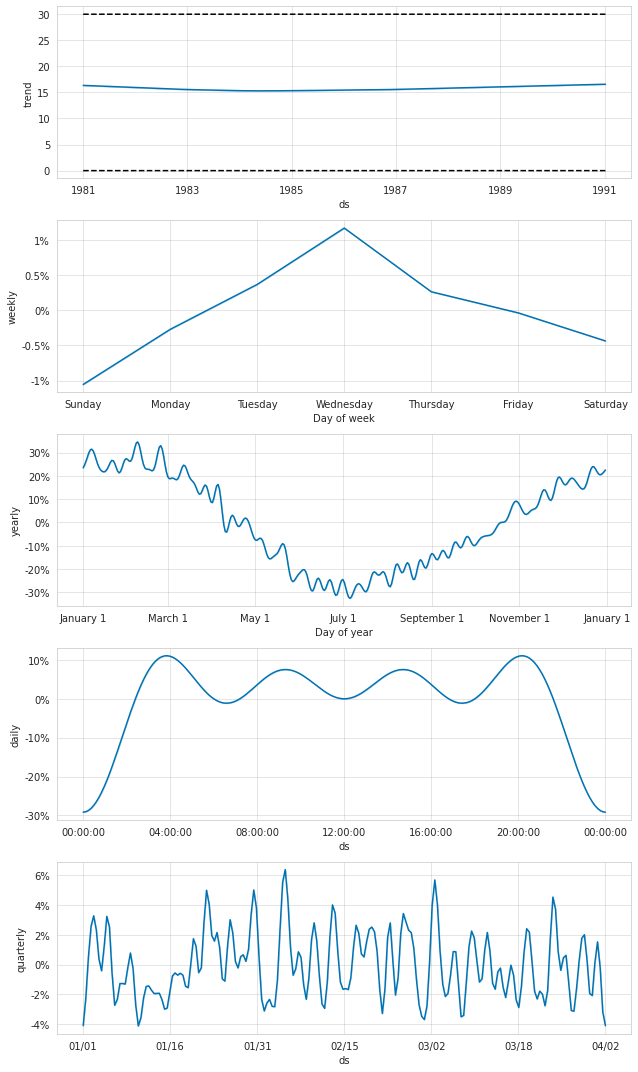

In [0]:
forecast_df = m.predict(future_set)
figure_forecast = m.plot(forecast_df)
figure_forecast_components = m.plot_components(forecast_df)

In [0]:
forecast_df.head()

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,quarterly,quarterly_lower,quarterly_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1981-01-01,16.348912,30,0,13.029896,19.643362,16.348912,16.348912,-0.291575,-0.291575,-0.291575,-0.003186,-0.003186,-0.003186,0.046573,0.046573,0.046573,0.002633,0.002633,0.002633,0.239182,0.239182,0.239182,0.0,0.0,0.0,16.296822
1,1981-01-02,16.347782,30,0,11.631503,18.657678,16.347782,16.347782,-0.291575,-0.291575,-0.291575,-0.062679,-0.062679,-0.062679,-0.001717,-0.001717,-0.001717,-0.000376,-0.000376,-0.000376,0.230989,0.230989,0.230989,0.0,0.0,0.0,15.323118
2,1981-01-03,16.346652,30,0,11.813246,18.439394,16.346652,16.346652,-0.291575,-0.291575,-0.291575,-0.068485,-0.068485,-0.068485,0.007810,0.007810,0.007810,-0.004364,-0.004364,-0.004364,0.219643,0.219643,0.219643,0.0,0.0,0.0,15.227150
3,1981-01-04,16.345523,30,0,10.904151,17.806703,16.345523,16.345523,-0.291575,-0.291575,-0.291575,-0.121885,-0.121885,-0.121885,-0.029746,-0.029746,-0.029746,-0.010560,-0.010560,-0.010560,0.209996,0.209996,0.209996,0.0,0.0,0.0,14.353243
4,1981-01-05,16.344393,30,0,11.480298,17.880743,16.344393,16.344393,-0.291575,-0.291575,-0.291575,-0.103425,-0.103425,-0.103425,-0.014374,-0.014374,-0.014374,-0.002717,-0.002717,-0.002717,0.205241,0.205241,0.205241,0.0,0.0,0.0,14.653976


### Combining Actual and Predicted values based on date

In [0]:
actual_forecasted = forecast_df.set_index(['ds'])[['yhat']].join(test_set.set_index('ds')).dropna()
actual_forecasted.reset_index(inplace=True)
actual_forecasted['ds'] = actual_forecasted.ds.astype(str)
actual_forecasted.set_index(['ds'],inplace=True)

In [0]:
actual_forecasted.head()

,yhat,y,month
ds,,,
1990-01-01,15.227872,14.8,1.0
1990-01-02,14.562594,13.3,1.0
1990-01-03,14.867366,15.6,1.0
1990-01-04,15.293937,14.5,1.0
1990-01-05,14.862046,14.3,1.0


In [0]:
actual_forecasted.columns=['predicted','actual','month']

### Visualizing actual temperatures vs forecasted temperature using FB Prophet 

Text(0.5, 1.0, 'Actual vs Forecasted')

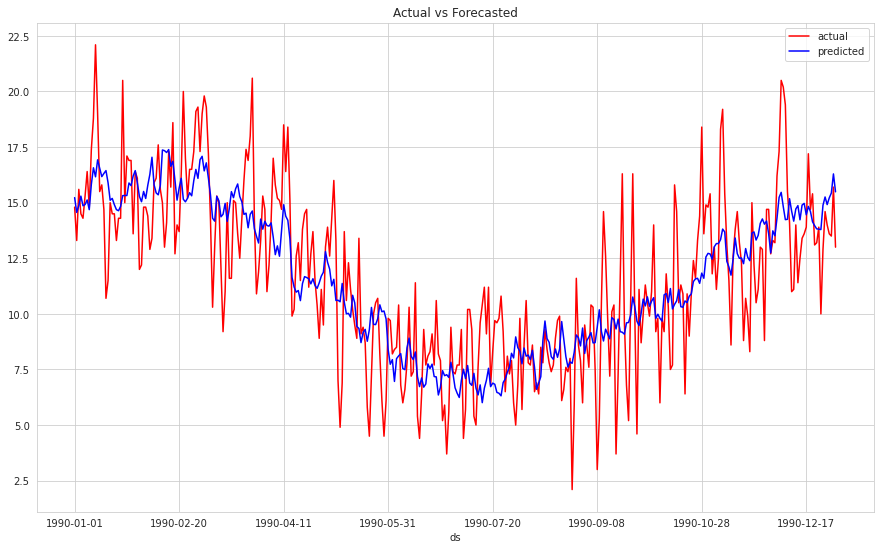

In [0]:
plt.figure(figsize=(15,9))
actual_forecasted['actual'].plot(color='red')
actual_forecasted['predicted'].plot(color='blue')
plt.legend(loc='best')
plt.title('Actual vs Forecasted')

In [0]:
actual_forecasted['residual'] = actual_forecasted['predicted'] - actual_forecasted['actual']
actual_forecasted.describe().T

,count,mean,std,min,25%,50%,75%,max
predicted,365.0,11.643400,3.188394,6.007616,8.796953,11.453277,14.638679,17.388370
actual,365.0,11.669589,3.861600,2.100000,8.700000,11.400000,14.600000,22.100000
month,365.0,6.526027,3.452584,1.000000,4.000000,7.000000,10.000000,12.000000
residual,365.0,-0.026189,2.422255,-7.125942,-1.526324,-0.000234,1.387175,6.401357


### Model Evaluation and Performance Metrics 



In [0]:
y_true, y_pred = np.array(actual_forecasted.actual), np.array(actual_forecasted.predicted)
df_1 = pd.DataFrame(y_true,columns=['y_true'])
df_1['y_pred'] = y_pred
df_1['resi'] = df_1.y_true - df_1.y_pred
df_1['resi_sct'] = np.where(df_1['resi'] == 0 , 0, np.abs(df_1['resi']/df_1.y_true))
df_1['mape'] = np.where(df_1['resi_sct'] == 0 , 0, np.mean(df_1['resi_sct']))



print('r squared : ' , (r2_score(actual_forecasted.actual, actual_forecasted.predicted)* 100))

print('mean squared error : ' , mean_squared_error(actual_forecasted.actual, actual_forecasted.predicted))

print('mean absolute error : ' , mean_absolute_error(actual_forecasted.actual, actual_forecasted.predicted))

print('mean absolute percentage error : ' , df_1.mape.unique()[0])


r squared :  60.64898185078575
mean squared error :  5.851930271639045
mean absolute error :  1.87992430751294
mean absolute percentage error :  0.19738490314676183


In [0]:
actual_forecasted.reset_index(inplace=True)

In [0]:
actual_forecasted.groupby(['month'])['actual','predicted'].mean()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



,actual,predicted
month,,
1.0,15.577419,15.546057
2.0,15.417857,15.959749
3.0,14.835484,15.019111
4.0,13.433333,12.480938
5.0,9.748387,10.217701
6.0,7.720000,7.520498
7.0,8.183871,7.027160
8.0,7.825806,8.242606
9.0,9.166667,9.431733


# Alternative Approach

# Cross Validation - Diagnostics  

In [0]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

df_cv = cross_validation(m, initial='3285 days', period='365 days',horizon='365 days')
df_cv.head()

INFO:fbprophet:Making 1 forecasts with cutoffs between 1989-12-31 00:00:00 and 1989-12-31 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1990-01-01,15.423458,12.145013,18.692094,14.8,1989-12-31
1,1990-01-02,14.917351,11.265019,18.286504,13.3,1989-12-31
2,1990-01-03,15.005665,11.595483,18.168517,15.6,1989-12-31
3,1990-01-04,15.426364,11.892265,18.918715,14.5,1989-12-31
4,1990-01-05,15.100560,11.958291,18.475309,14.3,1989-12-31


# Performance Metrics - Diagnostics

In [0]:
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,36 days,5.747309,2.397354,1.725219,0.117647,0.072777,0.833333
1,37 days,6.127125,2.475303,1.812066,0.124551,0.078077,0.805556
2,38 days,6.490368,2.547620,1.877178,0.129385,0.078077,0.777778
3,39 days,6.480767,2.545735,1.863086,0.128479,0.078077,0.777778
4,40 days,6.463727,2.542386,1.851095,0.127558,0.078077,0.777778


# Visualizing MAPE Score for Cross Validation Model

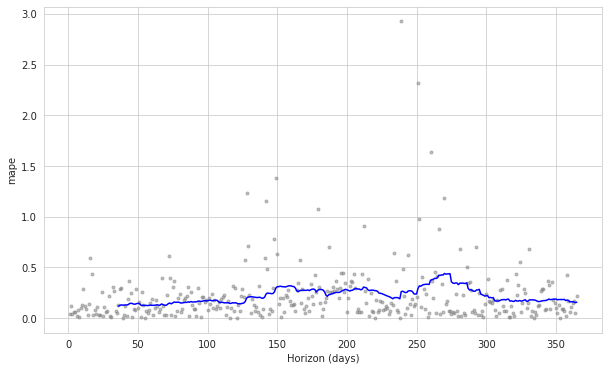

In [0]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [0]:
one_year = df_cv

# Visualizing Actual and Predicted Values using Diagnostics Method

Text(0.5, 1.0, 'Actual vs Forecasted')

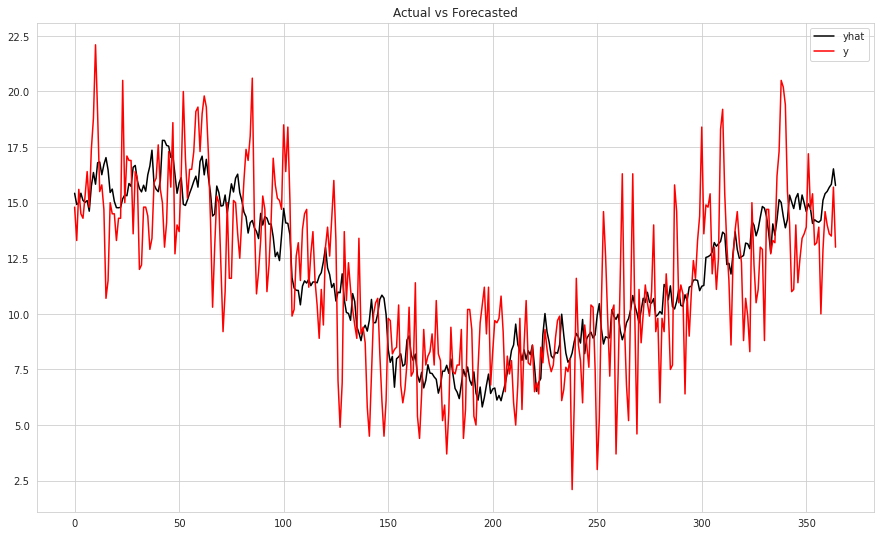

In [0]:
plt.figure(figsize=(15,9))
one_year['yhat'].plot(color='black')
one_year['y'].plot(color='red')
plt.legend(loc='best')
plt.title('Actual vs Forecasted')

# Evaluation / Performace Metrics 

In [0]:
y_true, y_pred = np.array(one_year.y), np.array(one_year.yhat)
df_1 = pd.DataFrame(y_true,columns=['y_true'])
df_1['y_pred'] = y_pred
df_1['resi'] = df_1.y_true - df_1.y_pred
df_1['resi_sct'] = np.where(df_1['resi'] == 0 , 0, np.abs(df_1['resi']/df_1.y_true))
df_1['mape'] = np.where(df_1['resi_sct'] == 0 , 0, np.mean(df_1['resi_sct']))



print('R squared : ' , (r2_score(one_year.y, one_year.yhat)* 100))

print('Mean squared error : ' , mean_squared_error(one_year.y, one_year.yhat))

print('Mean absolute error : ' , mean_absolute_error(one_year.y, one_year.yhat))

print('Mean absolute percentage error : ' , df_1.mape.unique()[0])


r squared :  54.561597589446386
mean squared error :  6.75719142902392
mean absolute error :  2.0300820652238194
mean absolute percentage error :  0.21367725477877672


In [0]:
df_1.describe().T

,count,mean,std,min,25%,50%,75%,max
y_true,365.0,11.669589,3.861600e+00,2.100000,8.700000,11.400000,14.600000,22.100000
y_pred,365.0,11.748838,3.244034e+00,5.815357,8.927736,11.398311,14.793049,17.803684
resi,365.0,-0.079249,2.601818e+00,-6.945164,-1.560951,-0.207595,1.480820,7.463925
resi_sct,365.0,0.213677,2.820718e-01,0.001026,0.065488,0.135607,0.269752,2.925156
mape,365.0,0.213677,5.558735e-16,0.213677,0.213677,0.213677,0.213677,0.213677


In [0]:
###################################################################################################################